In [37]:
'''
Script to compare CT values across clades.
Heatmap generated using Python and R
p-values generated using R read in as "r_pval"
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from scipy.stats import mannwhitneyu, wilcoxon
import itertools
from collections import OrderedDict
from itertools import compress
from statsmodels.stats.multitest import multipletests

df = pd.read_csv('/Users/tlh4362/Desktop/final_dataset_analysis_11_2.csv')

ct = pd.read_csv('/Users/tlh4362/Downloads/SARSCoV2Biobank-QPCRct_DATA_2022-10-10_0848.csv')

r_pval = pd.read_csv('/Users/tlh4362/Desktop/emm_clades.csv')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9,19,28,29,52,54,58,91,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
df = pd.merge(df, ct.loc[:,['record_id', 'ct_n1']], how = 'left', on = 'record_id')
df['ct_n1'] = df['ct_n1'].replace({'undetermined':None,'Undetermined':None, 'Undetermind':None })
df['ct_n1'] = df['ct_n1'].astype(float)

In [39]:
pairs = list(itertools.combinations(list(df['Clade'].value_counts().index), 2))
mannwhiteney_pval_df = pd.DataFrame(index = list(df['Clade'].value_counts().index), columns = list(df['Clade'].value_counts().index))
for pair in pairs:
    clade1 = pair[0]
    clade2 = pair[1]
    pval = mannwhitneyu(df[df['Clade']==clade1]['ct_n1'], df[df['Clade']==clade2]['ct_n1']).pvalue
    mannwhiteney_pval_df.at[clade2, clade1] = pval
mannwhiteney_pval_df

,21J/I/A (Delta),21M/K/L (Omicron),20G,"20I (Alpha, V1)",20A,Other,20C,20B
21J/I/A (Delta),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21M/K/L (Omicron),1.37156e-35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20G,0.00134734,1.04392e-06,NaN,NaN,NaN,NaN,NaN,NaN
"20I (Alpha, V1)",0.000376613,0.0189252,0.141973,NaN,NaN,NaN,NaN,NaN
20A,0.000301118,0.0321066,0.126623,0.498697,NaN,NaN,NaN,NaN
Other,0.00243142,0.00383547,0.304248,0.354771,0.294091,NaN,NaN,NaN
20C,2.42282e-05,0.188791,0.0381353,0.257326,0.267969,0.125146,NaN,NaN
20B,0.343689,2.37963e-05,0.129863,0.0354359,0.0273183,0.102118,0.00992401,NaN


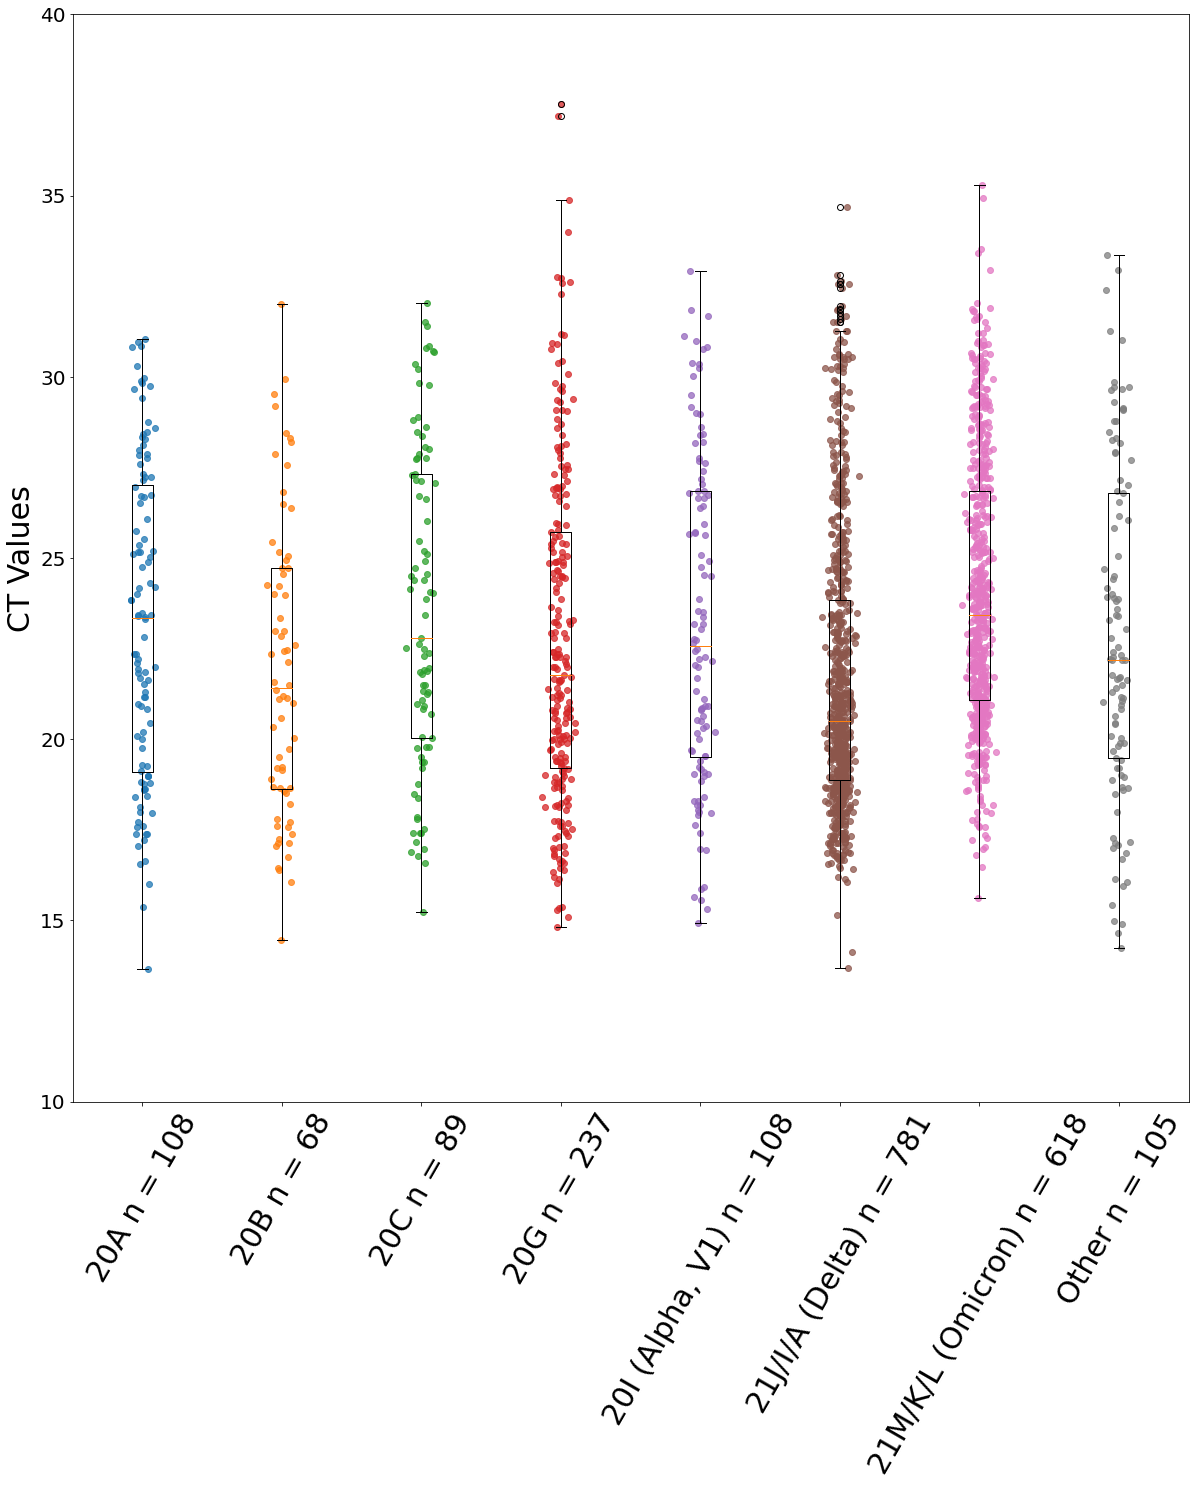

In [40]:
#jitter plots for CT values per clade

complete_formula = 'ct_n1~Clade+clinical_outcome+Number_of_vaccination_doses_before_infection+Clade*clinical_outcome'
model = sm.GLM.from_formula(complete_formula, family = sm.families.Gaussian(), data = df)
result = model.fit()

clade_df = df[df['Clade'].notnull()]
plt.figure(figsize = [20,20])
plt.ylim(10,40)
ordered_clades_list = ['20A','20B','20C','20G', '20I (Alpha, V1)', '21J/I/A (Delta)', '21M/K/L (Omicron)', 'Other']

for c in range(len(ordered_clades_list)):

    tmp_ct = df[df['Clade']==ordered_clades_list[c]]['ct_n1'].dropna()
    plt.boxplot(tmp_ct,positions = [c], labels = ['{} n = {}'.format(ordered_clades_list[c], tmp_ct.shape[0])])
    jitters = np.random.normal(c , 0.04, tmp_ct.shape[0])
    plt.scatter(jitters, tmp_ct, alpha = 0.75)

plt.xticks(rotation = 60, fontsize = 30)
plt.yticks(fontsize = 20)
plt.ylabel('CT Values', fontsize = 30)
# plt.title('Comparison using Mann Whitney')
# plt.savefig('/Users/tlh4362/Desktop/fig4/fig4a.eps', format = 'eps', bbox_inches = 'tight' )
plt.show()



In [42]:
df['Number_of_vaccination_doses_before_infection'] = df['Number_of_vaccination_doses_before_infection'].astype(str)

In [43]:
df = df[df['Number_of_vaccination_doses_before_infection']!='4']
df = df[df['Number_of_vaccination_doses_before_infection']!='5']

In [45]:
pval_df = pd.DataFrame(index = ['20A', '20B', '20C', '20G', '20I (Alpha, V1)',  '21J/I/A (Delta)', '21M/K/L (Omicron)', 'Other'], columns = ['20A', '20B', '20C', '20G', '20I (Alpha, V1)',  '21J/I/A (Delta)', '21M/K/L (Omicron)', 'Other'])
pairs = list(itertools.combinations(['20A', '20B', '20C', '20G', '20I (Alpha, V1)',  '21J/I/A (Delta)', '21M/K/L (Omicron)', 'Other'], 2))
mannwhitney_dict = {}
for pair in pairs:
    clade1 = pair[0]
    clade2 = pair[1]
    pval = mannwhitneyu(df[df['Clade']==clade1]['ct_n1'], df[df['Clade']==clade2]['ct_n1']).pvalue
    mannwhitney_dict['{}-{}'.format(clade2, clade1)] = pval
    if '{} - {}'.format(clade1, clade2) in list(r_pval['contrast']):
        pval_df.at[clade1, clade2] = r_pval[r_pval['contrast']=='{} - {}'.format(clade1, clade2)]['p.value'].iloc[0]
    else:
        pval_df.at[clade1, clade2] = r_pval[r_pval['contrast']=='{} - {}'.format(clade2, clade1)]['p.value'].iloc[0]

for pair, pval in zip(list(mannwhitney_dict.keys()), multipletests(list(mannwhitney_dict.values()), method = 'fdr_bh')[1]):
    clade1 = pair.split('-')[0]
    clade2 = pair.split('-')[1]
    pval_df.at[clade1, clade2] = pval
        

Text(0.5, -0.1, 'CT Values pairwise comparison, Mann-Whitney U + BH post-hoc from GLM')

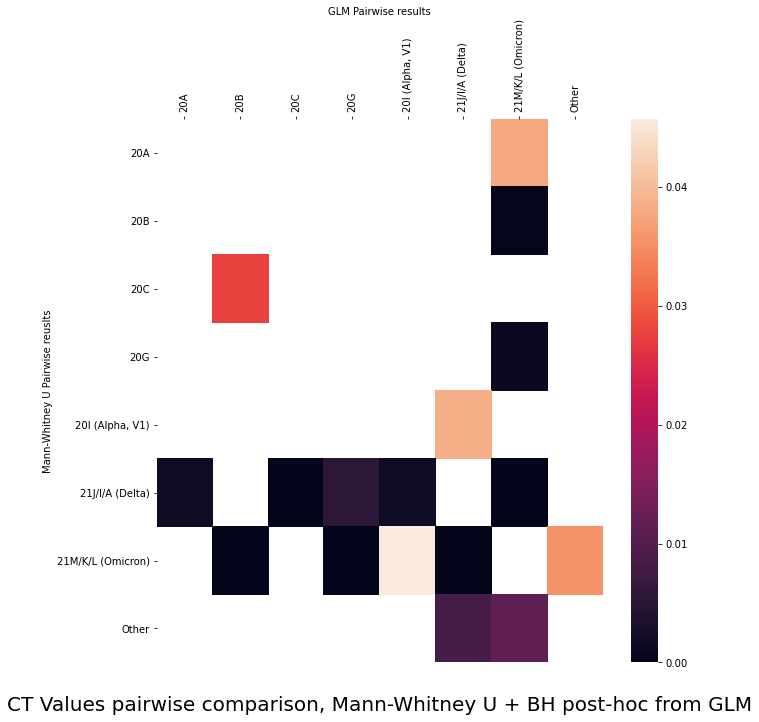

In [47]:
mask = pval_df>0.05
fig, ax = plt.subplots(figsize = (10, 10))
fig
for c in pval_df.columns:
    pval_df[c] = pval_df[c].astype(float)
sns.heatmap(pval_df, mask = mask, ax = ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xticklabels(labels = pval_df.index, rotation=90)
ax.set_xlabel('GLM Pairwise results')

ax.set_ylabel('Mann-Whitney U Pairwise reuslts')

plt.title('CT Values pairwise comparison, Mann-Whitney U + BH post-hoc from GLM', fontsize = 20, y = -0.1)

# plt.savefig('/Users/tlh4362/Desktop/fig4/fig4b.eps', format = 'eps', bbox_inches = 'tight')

In [48]:
df['Number_of_vaccination_doses_before_infection'] = df['Number_of_vaccination_doses_before_infection'].astype(float)

In [49]:
for vaxnum in range(4):
    ct1 = df[(df['Clade']=='21J/I/A (Delta)') & (df['Number_of_vaccination_doses_before_infection']==vaxnum)]['ct_n1'].dropna()
    ct2 = df[(df['Clade']=='21M/K/L (Omicron)') & (df['Number_of_vaccination_doses_before_infection']==vaxnum)]['ct_n1'].dropna()
    print('p-value for {} vaccine doses:'.format(vaxnum), mannwhitneyu(ct1, ct2).pvalue)
    
    
    
    

p-value for 0 vaccine doses: 4.738132514199928e-05
p-value for 1 vaccine doses: 5.168642692745555e-05
p-value for 2 vaccine doses: 3.861960617962309e-17
p-value for 3 vaccine doses: 0.08857749497265238


0 21J/I/A (Delta) 262
0 21M/K/L (Omicron) 103
1 21J/I/A (Delta) 48
1 21M/K/L (Omicron) 34
2 21J/I/A (Delta) 429
2 21M/K/L (Omicron) 169
3 21J/I/A (Delta) 42
3 21M/K/L (Omicron) 303


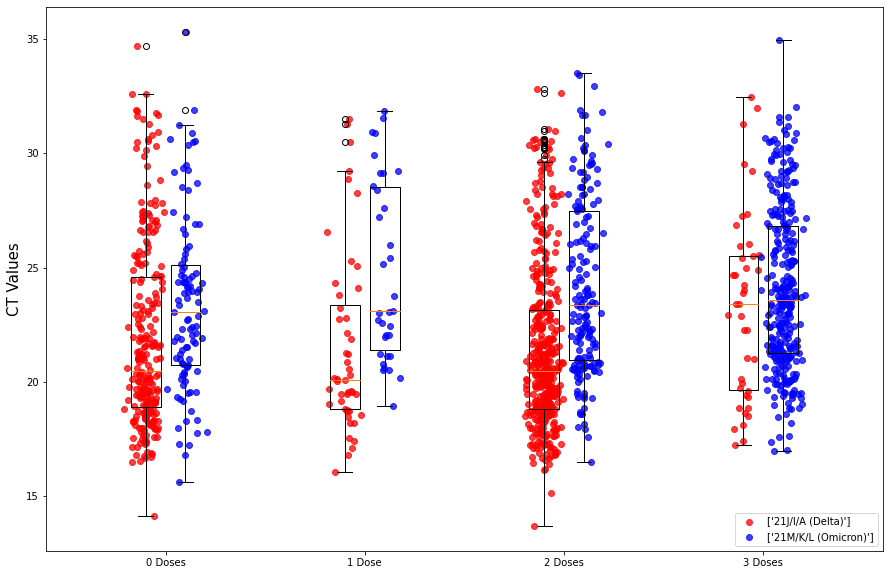

In [50]:

ordered_clades_list = ['21J/I/A (Delta)', '21M/K/L (Omicron)']
plt.figure(figsize = [15,10])
for vaxnum in range(4):
    for clade in ordered_clades_list:
        if clade == ordered_clades_list[0]:

            tmp_ct = df[(df['Clade']==clade) & (df['Number_of_vaccination_doses_before_infection']==vaxnum)]['ct_n1'].dropna()
            print(vaxnum, clade, tmp_ct.shape[0])
            plt.boxplot(tmp_ct, positions = [vaxnum-0.1], labels = ['vaccination before infection:{} n = {}'.format(vaxnum, tmp_ct.shape[0])])
            jitters = np.random.normal(vaxnum-0.1 , 0.04, tmp_ct.shape[0])
            plt.scatter(jitters, tmp_ct, alpha = 0.75, color = 'r', label = [clade])
        else:
            tmp_ct = df[(df['Clade']==clade) & (df['Number_of_vaccination_doses_before_infection']==vaxnum)]['ct_n1'].dropna()
            print(vaxnum, clade, tmp_ct.shape[0])
            plt.boxplot(tmp_ct, positions = [vaxnum+0.1], labels = ['vaccination before infection:{} n = {}'.format(vaxnum, tmp_ct.shape[0])])
            jitters = np.random.normal(vaxnum+0.1 , 0.04, tmp_ct.shape[0])
            plt.scatter(jitters, tmp_ct, alpha = 0.75, color = 'b', label = [clade])

plt.xticks(ticks = [0,1,2,3], labels = ['0 Doses', '1 Dose', '2 Doses', '3 Doses'])
plt.ylabel('CT Values', fontsize = 15)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,         
    labelbottom=True) 

# plt.savefig('/Users/tlh4362/Desktop/fig4/fig4c.eps', format = 'eps', bbox_inches = 'tight')
